In [120]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 24, 8
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold, SelectFdr

sns.set_context(context='notebook')
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [2]:
def make_dicts(df):
    f_dicts ={}
    
    features_dict = {}
    for x in ['ind', 'reg', 'car', 'calc']:
        for y in ['cat', 'bin', 'con']:
            features_dict[x+'_'+y] =[]
            for i in df.columns.tolist()[2:]:
                j = i.split('_')
                if len(j) == 3:
                    j.append('con')
                if j[1]==x and j[3]==y:
                    features_dict[x+'_'+y].append(i)
    f_dicts['combo'] = features_dict
    
    features_dict_data_type = {}
    for y in ['cat', 'bin', 'con']:
        features_dict_data_type[y]=[]
        for i in df.columns.tolist()[2:]:
            j = i.split('_')
            if len(j) == 3:
                j.append('con')
            if j[3]==y:
                features_dict_data_type[y].append(i)
    f_dicts['type'] = features_dict_data_type
    
    features_dict_data_label = {}
    for x in ['ind', 'reg', 'car', 'calc']:
        features_dict_data_label[x] =[]
        for i in df.columns.tolist()[2:]:
            j = i.split('_')
            if j[1]==x:
                features_dict_data_label[x].append(i)
    f_dicts['label'] = features_dict_data_label
    return f_dicts

In [3]:
def prepare_data():
    non_imp = ['ps_ind_12_bin','ps_ind_13_bin','ps_ind_18_bin','ps_car_10_cat','ps_ind_11_bin','ps_ind_10_bin']
    
    train = (pd.read_csv('../data/train.csv', na_values=999)
              .fillna(value=999))
    unwanted = list((set(train.columns[train.columns.str.startswith('ps_calc_')])|set(non_imp)))
    train.drop(unwanted, axis=1, inplace=True)
            
    test  = (pd.read_csv('../data/test.csv', na_values=999)
              .fillna(value=999)
              .drop(unwanted, axis=1)) 
            
    X = train.drop(['id', 'target'], axis=1).values
    y = train.target.values
    test_id = test.id.values
    test = test.drop('id', axis=1)

    
    f_dicts = make_dicts(train)

    train_cat = np.array(train[f_dicts['type']['cat']])
    train_cat[:,:] = np.add(train_cat[:,:],np.ones((train_cat.shape[0],train_cat.shape[1])))
    test_cat  = np.array(test[f_dicts['type']['cat']])
    test_cat[:,:] =  np.add(test_cat[:,:],np.ones((test_cat.shape[0],train_cat.shape[1])))

    OH = OneHotEncoder()
    OH.fit(np.array(list(train_cat) + list(test_cat)))
    train_cat = OH.transform(train_cat).toarray()
    test_cat = OH.transform(test_cat).toarray()

    train_con = np.array(train[f_dicts['type']['con']])
    test_con  = np.array(test[f_dicts['type']['con']])
    RS = StandardScaler()
    RS.fit(list(train_con) + list(test_con))
    train_con = RS.transform(train_con)
    train_con = RS.transform(train_con)

    train_bin = np.array(train[f_dicts['type']['bin']])
    test_bin = np.array(test[f_dicts['type']['bin']])


    X = np.hstack((train_cat,train_con,train_bin))

    X_test = np.hstack((test_cat,test_con,test_bin))
    
    return X, y, X_test, test_id

In [4]:
X, y, X_test, test_id = prepare_data()

In [147]:
Z = linkage(X[:50000,:].T, method='average',metric='euclidean')

In [148]:
c, coph_dists = cophenet(Z, pdist(X[:50000,:].T))
c

0.99782443694139333

In [149]:
Z[:]

array([[    5.     ,    16.     ,     1.41421,     2.     ],
       [   29.     ,   199.     ,     2.64575,     3.     ],
       [    0.     ,   200.     ,     3.08747,     4.     ],
       [   39.     ,   201.     ,     4.41221,     5.     ],
       [   42.     ,   202.     ,     4.76736,     6.     ],
       [   40.     ,   203.     ,     7.14383,     7.     ],
       [   71.     ,   204.     ,     7.52085,     8.     ],
       [   38.     ,   205.     ,     8.37038,     9.     ],
       [  139.     ,   206.     ,    10.04845,    10.     ],
       [   94.     ,   207.     ,    10.87236,    11.     ],
       [   56.     ,   208.     ,    11.20784,    12.     ],
       [  132.     ,   209.     ,    11.73013,    13.     ],
       [   18.     ,   210.     ,    12.0776 ,    14.     ],
       [   53.     ,   211.     ,    12.93534,    15.     ],
       [  157.     ,   212.     ,    13.12604,    16.     ],
       [   14.     ,   213.     ,    13.37947,    17.     ],
       [  111.     ,   2

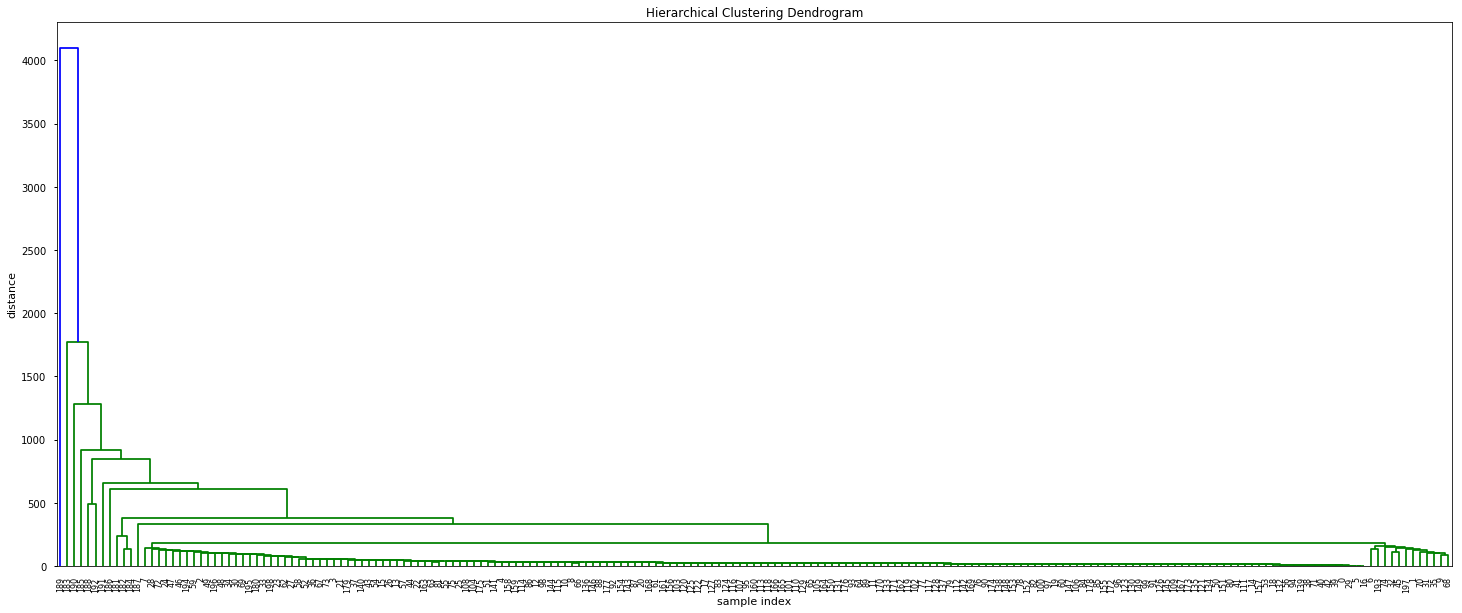

In [151]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
b = dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [167]:
25*8

200

In [173]:
14*14

196

In [159]:
198/11

18.0

In [180]:
inds = np.reshape([int(x) for x in b['ivl'][:-3]], (14,14))

In [182]:
inds

array([[189, 183, 190, 185, 188, 192, 191, 186, 181, 182, 184, 187,   7,
         28],
       [ 72,  24,  47,  46, 194,  59,   2,  49, 196,  48,  34,  30,  69,
        195],
       [180,  33, 198,  23,  62,  27,  58,  52,  36,  67,  73,   3,  21,
        179],
       [ 37, 140,  43,  54,  15,  26,  13,  57,  44,  22, 163,  63,  81,
         55],
       [ 75,  25, 108, 104, 175,  51, 141,   4, 158, 159, 114,  86,  12,
         98],
       [144, 115,  10,   8,  66, 136, 146,  88, 177,  92, 154, 143,  87,
         20],
       [168,  61, 161, 156, 103, 120, 125, 122,  17, 127,  83, 124, 116,
        107],
       [ 95, 160, 113, 118, 166, 165, 101, 110, 129,  65, 105, 164, 150,
        131],
       [176,  93,  64,  89,  11, 170, 133, 171, 162, 119, 102,  77, 117,
        128],
       [137,  79, 112, 142, 169,  76,  90, 174, 138, 148, 153,  78, 152,
         82],
       [100,  97,  19,  60, 147, 106,  84, 178,  85, 155, 172,  96, 123,
        130],
       [149,  99,  91, 126, 145, 109, 167, 

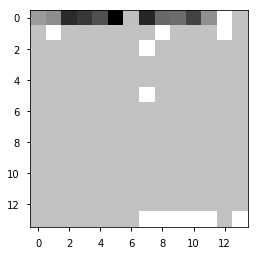

In [203]:
plt.imshow(X[6252][inds])
plt.gray()

In [87]:
selector = VarianceThreshold(0.04875)

In [88]:
X_ = selector.fit_transform(X)

In [89]:
X.shape

(595212, 199)

In [108]:
X_[:11000,:].shape

(11000, 49)

In [91]:
np.vstack((X_[0][[2,6,1,3 ,5,6,8,3,24]],X_[0][[2,6,1,3 ,5,6,8,3,24]]))

array([[ 0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.]])

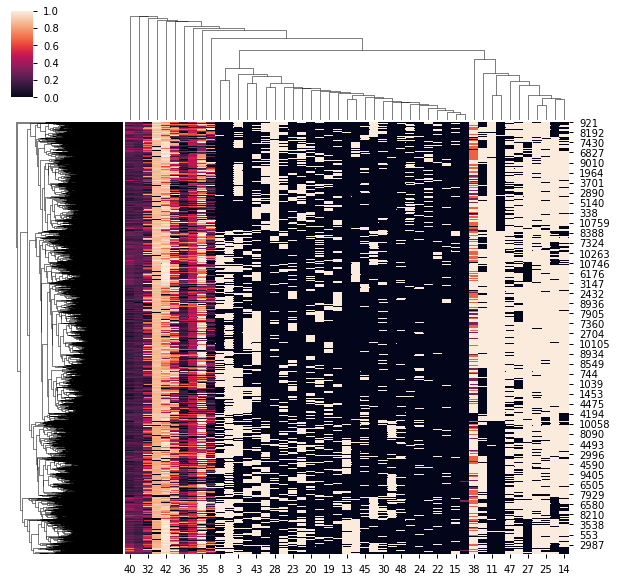

In [109]:
g = sns.clustermap(X_[:11000,:], linewidth=0, metric="hamming",standard_scale=1)
plt.show()

In [105]:
lst_ord = []
for i in g.ax_heatmap.xaxis.get_majorticklabels():
    lst_ord.append(i.get_text())

In [106]:
len(lst_ord)

25

In [110]:
np.reshape(lst_ord,newshape=(5,5))

array([['23', '11', '27', '6', '43'],
       ['10', '34', '4', '21', '0'],
       ['7', '28', '31', '24', '44'],
       ['39', '15', '26', '13', '22'],
       ['36', '37', '29', '33', '48']],
      dtype='<U2')

In [ ]:
g.dendrogram_col.linkage